In [2]:
import pandas as pd
import os
from dotenv import load_dotenv
import ast

# Import LangChain's ChatOpenAI
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

# Load OpenAI API key from .env file
if not load_dotenv():
    raise Exception('Error loading .env file. Make sure to place a valid OPENAI_API_KEY in the .env file.')

api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise Exception('Error loading OPENAI_API_KEY from .env file. Make sure to place a valid OPENAI_API_KEY in the .env file.')

# Initialize the ChatOpenAI object
chat = ChatOpenAI(temperature=0, openai_api_key=api_key)

C:\Users\bokovacs\AppData\Local\Temp\ipykernel_24364\1699778471.py:19: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  chat = ChatOpenAI(temperature=0, openai_api_key=api_key)


In [3]:

def convert_units(df):
    """
    Converts values in the DataFrame to a canonical unit per metric, considering the units present.
    Also determines the direction of the metric regarding sustainability (-1, 0, or 1).

    Parameters:
    df (pd.DataFrame): DataFrame containing at least the columns 'metric', 'value', 'unit'.

    Returns:
    pd.DataFrame: DataFrame with new columns 'Converted value', 'Canonical unit', and 'Direction'.
    """
    # Initialize dictionaries to store canonical units, conversion factors, and directions
    canonical_units = {}
    unit_conversion_factors = {}
    metric_directions = {}

    # Determine canonical units, build conversion factors, and determine directions
    for metric in df['metric'].unique():
        # Get the list of units for the current metric
        units = df[df['metric'] == metric]['unit'].unique().tolist()
        # Get the canonical unit for the metric using the LLM, considering the units present
        canonical_unit = get_canonical_unit(metric, units)
        if not canonical_unit:
            print(f"Could not determine canonical unit for metric '{metric}'. Skipping.")
            continue
        canonical_units[metric] = canonical_unit
        unit_conversion_factors[metric] = {}
        for unit in units:
            if unit == canonical_unit:
                unit_conversion_factors[metric][unit] = 1.0
            else:
                factor = get_conversion_factor(unit, canonical_unit)
                if factor:
                    unit_conversion_factors[metric][unit] = factor
                else:
                    # Handle cases where conversion factor could not be retrieved
                    unit_conversion_factors[metric][unit] = None  # Indicate failure to convert

        # Get the direction of the metric regarding sustainability
        direction = get_metric_direction(metric)
        if direction is not None:
            metric_directions[metric] = direction
        else:
            metric_directions[metric] = 0  # Default to neutral if unable to determine

    # Function to convert values to canonical units
    def convert_value(row):
        metric = row['metric']
        unit = row['unit']
        value = row['value']
        factor = unit_conversion_factors.get(metric, {}).get(unit)
        if factor is None:
            # Unable to convert; return None or handle as needed
            print(f"Unable to convert '{unit}' to '{canonical_units.get(metric)}' for metric '{metric}'.")
            return None
        return value * factor

    # Apply the conversion to the DataFrame
    df['Canonical unit'] = df['metric'].map(canonical_units)
    df['Converted value'] = df.apply(convert_value, axis=1)
    df['Direction'] = df['metric'].map(metric_directions)

    return df

def get_canonical_unit(metric, units):
    """
    Uses the LLM to determine the most appropriate canonical unit for a given metric, considering the units present.

    Parameters:
    metric (str): The name of the metric.
    units (list): List of units present for the metric.

    Returns:
    str: The canonical unit.
    """
    units_list = ', '.join(units)
    prompt = (
        f"For the metric '{metric}', considering the units '{units_list}', "
        f"what is the most appropriate unit to standardize on for comparison purposes? "
        f"Choose one of the provided units or suggest a compatible unit. Provide only the unit name."
    )
    messages = [
        SystemMessage(content="You are an expert in units of measurement. When asked, you provide only the most appropriate unit to standardize on for a given metric, considering the units provided, as a single word or phrase, nothing else."),
        HumanMessage(content=prompt)
    ]
    try:
        response = chat(messages)
        answer = response.content.strip()
        print(f"Canonical unit for metric '{metric}': {answer}")
        return answer
    except Exception as e:
        print(f"Error getting canonical unit for metric '{metric}': {e}")
        return None

def get_conversion_factor(source_unit, target_unit):
    """
    Uses the LLM to get the conversion factor from source_unit to target_unit.

    Parameters:
    source_unit (str): The unit to convert from.
    target_unit (str): The unit to convert to.

    Returns:
    float: The conversion factor.
    """
    prompt = f"What is the numerical conversion factor to convert '{source_unit}' to '{target_unit}'? Provide only the numerical conversion factor."
    messages = [
        SystemMessage(content="You are an expert in unit conversions. When asked, you provide only the numerical conversion factor as a single number, nothing else."),
        HumanMessage(content=prompt)
    ]
    try:
        response = chat(messages)
        answer = response.content.strip()
        # Remove commas from numbers to handle thousands separators
        answer = answer.replace(',', '')
        factor = float(answer)
        print(f"Conversion factor from '{source_unit}' to '{target_unit}': {factor}")
        return factor
    except Exception as e:
        print(f"Error getting conversion factor from '{source_unit}' to '{target_unit}': {e}")
        return None

def get_metric_direction(metric):
    """
    Uses the LLM to determine whether, for the given metric, a higher value is better, a lower value is better, or neutral in terms of sustainability.

    Parameters:
    metric (str): The name of the metric.

    Returns:
    int: Direction indicator (-1 for lower is better, 1 for higher is better, 0 for neutral).
    """
    prompt = (
        f"In terms of sustainability, for the metric '{metric}', is a higher value better, a lower value better, or is it neutral? "
        f"Please respond with '-1' if a lower value is better, '1' if a higher value is better, or '0' if it's neutral. Provide only the number."
    )
    messages = [
        SystemMessage(content="You are an expert in sustainability metrics. When asked about a metric, you provide only the direction indicator as a single number: '-1' if a lower value is better, '1' if a higher value is better, or '0' if it's neutral."),
        HumanMessage(content=prompt)
    ]
    try:
        response = chat(messages)
        answer = response.content.strip()
        # Ensure the answer is one of -1, 0, or 1
        if answer in ['-1', '0', '1']:
            direction = int(answer)
            print(f"Direction for metric '{metric}': {direction}")
            return direction
        else:
            print(f"Invalid direction response for metric '{metric}': {answer}")
            return None
    except Exception as e:
        print(f"Error getting direction for metric '{metric}': {e}")
        return None

In [4]:
esg_metrics_small = [
    'Carbon Emissions',
    'Energy Consumption',
    'Water Usage',
    'Waste Generation',
    'Renewable Energy Usage',
    'Greenhouse Gas Emissions Intensity',
    'Biodiversity Impact',
]

In [5]:
df_final = pd.read_csv("data/df_final.csv")

# Step 1: Filter rows where 'value' column contains a list with exactly one element and that element is a float
df_filtered = df_final[df_final['value'].apply(lambda x: len(ast.literal_eval(x)) == 1 )]

# Step 2: Convert the list with one element to a float
df_filtered['value'] = df_filtered['value'].apply(lambda x: float(x[1:-1]))

# Check the result
print(df_filtered.head())


  company  year            metric      value              unit
0  Amazon  2022  Carbon Emissions      70.74  metric tons CO2e
2     H&M  2017  Carbon Emissions   70165.00            tonnes
5   Apple  2012  Carbon Emissions  400000.00  metric tons CO2e
6   Apple  2011  Carbon Emissions  200000.00  metric tons CO2e
7      BP  2017  Carbon Emissions      48.80           MteCO2e


C:\Users\bokovacs\AppData\Local\Temp\ipykernel_24364\1984762136.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['value'] = df_filtered['value'].apply(lambda x: float(x[1:-1]))


In [6]:

# Convert the string into an actual Python list
converted_list = ast.literal_eval(df_final.loc[0, "value"])

In [7]:
df_converted_thomas = convert_units(df_filtered)

C:\Users\bokovacs\AppData\Local\Temp\ipykernel_24364\2651773165.py:87: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = chat(messages)


Canonical unit for metric 'Carbon Emissions': metric tons CO2e
Conversion factor from 'tonnes' to 'metric tons CO2e': 1.0
Conversion factor from 'MteCO2e' to 'metric tons CO2e': 1.0
Conversion factor from 'MtCO2e' to 'metric tons CO2e': 1.0
Conversion factor from 'Million Metric Tons (MT) CO2e' to 'metric tons CO2e': 1000000.0
Conversion factor from 'million tCO2e' to 'metric tons CO2e': 1000000.0
Conversion factor from 'tCO2e' to 'metric tons CO2e': 1000.0
Conversion factor from 'g CO₂/km' to 'metric tons CO2e': 1e-06
Conversion factor from 'g/km' to 'metric tons CO2e': 1e-06
Direction for metric 'Carbon Emissions': -1
Canonical unit for metric 'Energy Consumption': kWh
Conversion factor from 'billion kWh' to 'kWh': 1000000000.0
Conversion factor from 'million MWh' to 'kWh': 1000000.0
Direction for metric 'Energy Consumption': -1
Canonical unit for metric 'Water Usage': million cubic meters
Error getting conversion factor from 'Liters per kilowatt-hour (L/kWh)' to 'million cubic meter

C:\Users\bokovacs\AppData\Local\Temp\ipykernel_24364\2651773165.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Canonical unit'] = df['metric'].map(canonical_units)
C:\Users\bokovacs\AppData\Local\Temp\ipykernel_24364\2651773165.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Converted value'] = df.apply(convert_value, axis=1)
C:\Users\bokovacs\AppData\Local\Temp\ipykernel_24364\2651773165.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [9]:
def process_data(wanted_metric, df):
    # Step 1: Filter rows where 'metric' equals 'wanted_metric'
    df_filtered = df[df['metric'] == wanted_metric]

    # Step 2: Drop the specified columns
    df_dropped = df_filtered.drop(columns=['year', 'unit', 'value'])

    # Step 3: Group by 'company' and aggregate
    df_grouped = df_dropped.groupby('company', as_index=False).agg({
        'Converted value': 'mean',
        'metric': 'first',
        'Canonical unit': 'first',
        'Direction': 'first'
    })

    return df_grouped


In [10]:
averaged_carbon_emissions_df = process_data("Carbon Emissions", df_converted_thomas)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_companies(df, N):
    """
    Plots the top N companies based on the 'Converted value' column,
    considering the 'Direction' for sorting.

    Parameters:
    - df: DataFrame with required columns.
    - N: Number of companies to plot.
    """
    # Ensure the required columns are present
    required_columns = ['company', 'Converted value', 'metric', 'Canonical unit', 'Direction']
    if not all(column in df.columns for column in required_columns):
        raise valueError(f"The DataFrame must contain the following columns: {required_columns}")

    # Step 1: Get the Direction from the first row
    direction = df['Direction'].iloc[0]
    if direction not in [-1, 1]:
        raise valueError("Direction must be either -1 (low values are better) or 1 (high values are better)")

    # Step 2: Sort the DataFrame based on 'Converted value' and 'Direction'
    ascending_order = True if direction == -1 else False
    df_sorted = df.sort_values(by='Converted value', ascending=ascending_order)

    # Step 3: Select the top N companies
    df_topN = df_sorted.head(N)

    # Step 4: Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(df_topN['company'], df_topN['Converted value'], color='skyblue')

    # Add value labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + max(df_topN['Converted value'])*0.01, 
                 f'{yval:.2f}', ha='center', va='bottom')

    # Labeling the axes and setting the title
    plt.xlabel('company')
    plt.ylabel(f'Converted value ({df["Canonical unit"].iloc[0]})')
    plt.title(f'Top {N} Companies for metric "{df["metric"].iloc[0]}"')

    # Rotate x-axis labels if necessary
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [13]:
def plot_top_n_metrics(df, desired_metric, N):
    average_df = process_data(desired_metric, df)
    plot_companies(average_df, N)

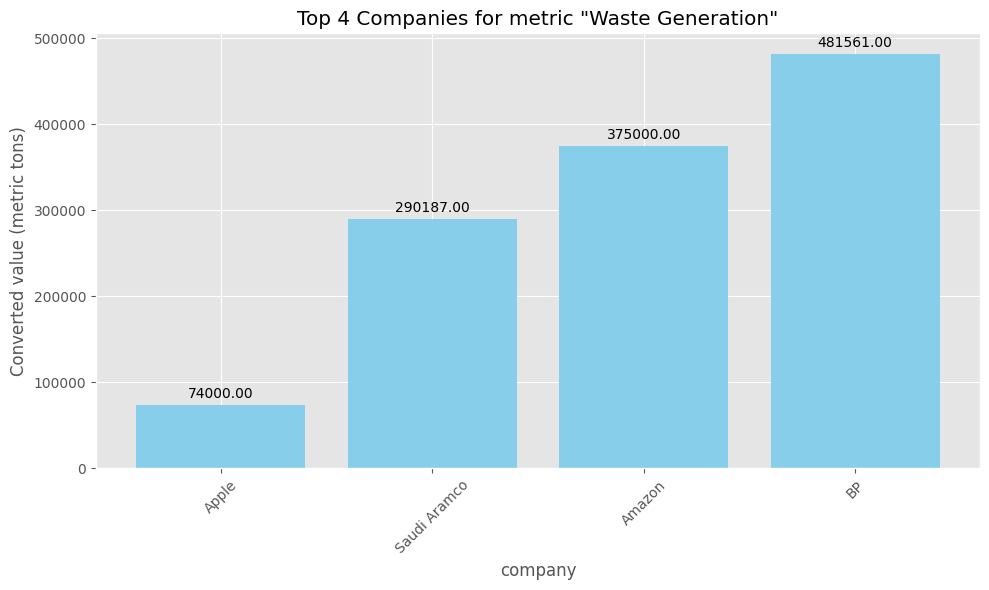

In [14]:
plot_top_n_metrics(df_converted_thomas, 'Waste Generation', 4)

convert_units(df) # must be 'company', 'year', 'metric', 'value', 'unit'
plot_top_n_metrics(df, str of metric, Number of plotted)

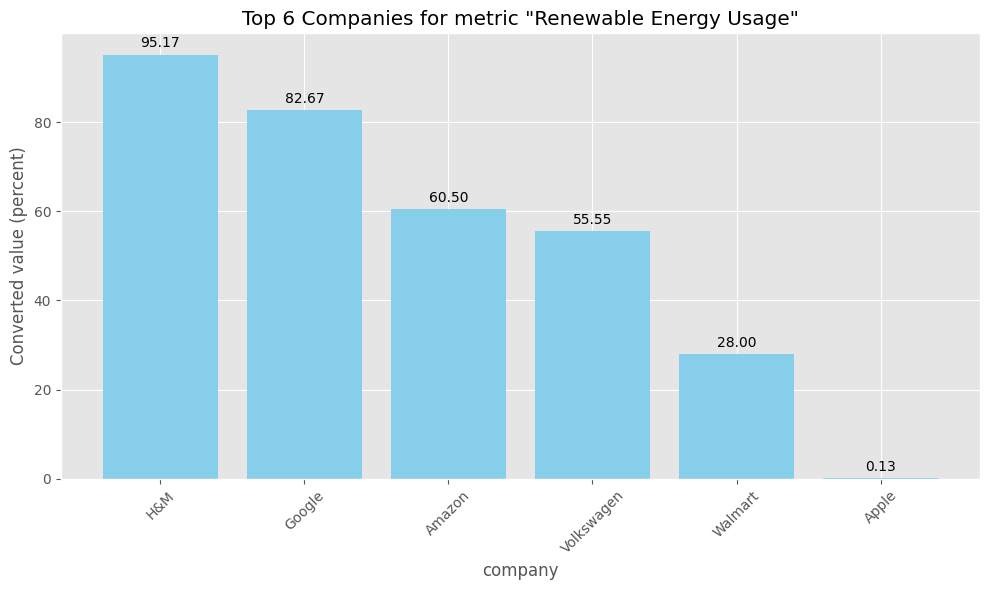

In [15]:

plot_top_n_metrics(df_converted_thomas, 'Renewable Energy Usage', 6)


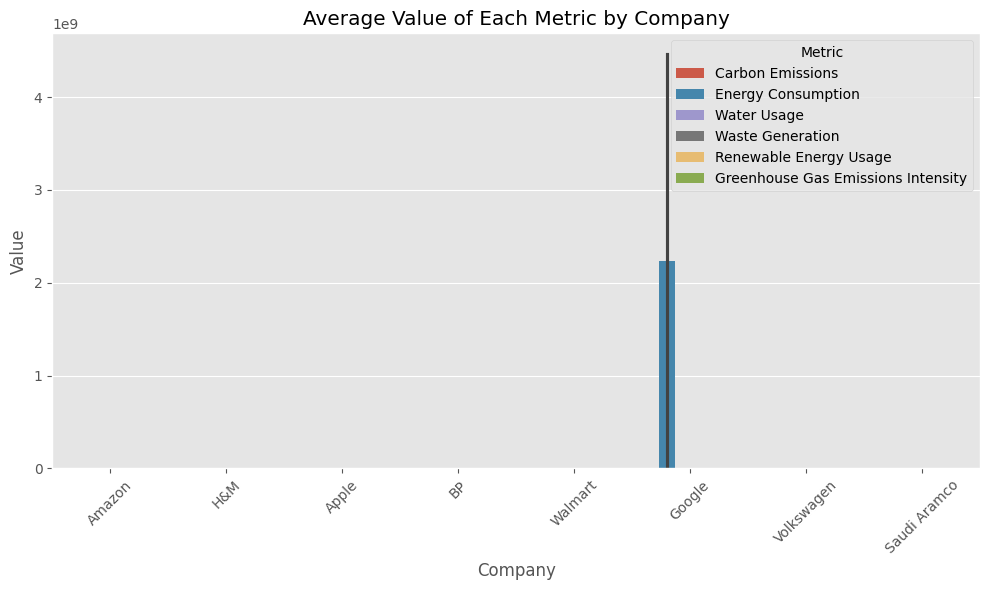

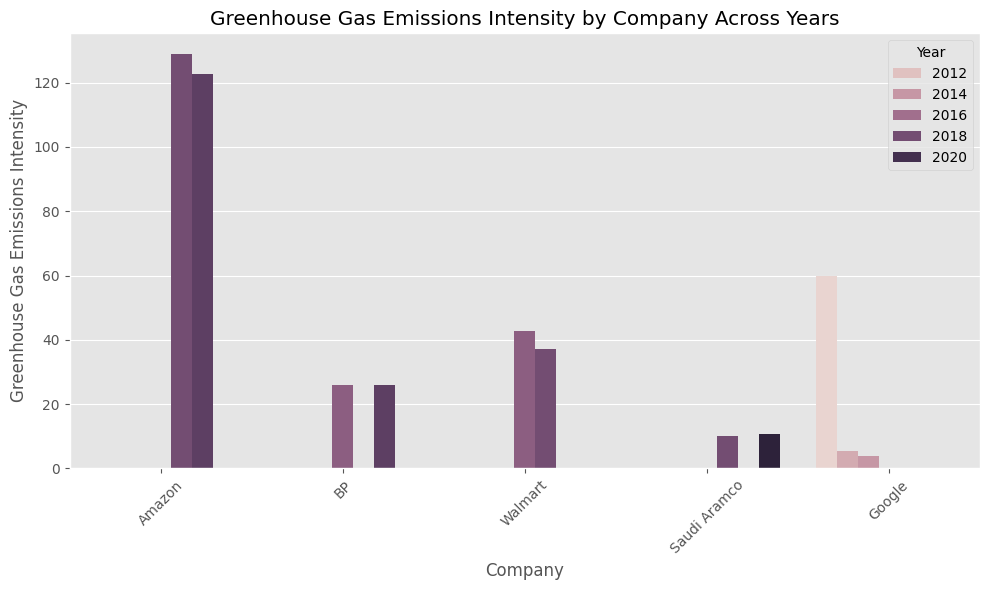

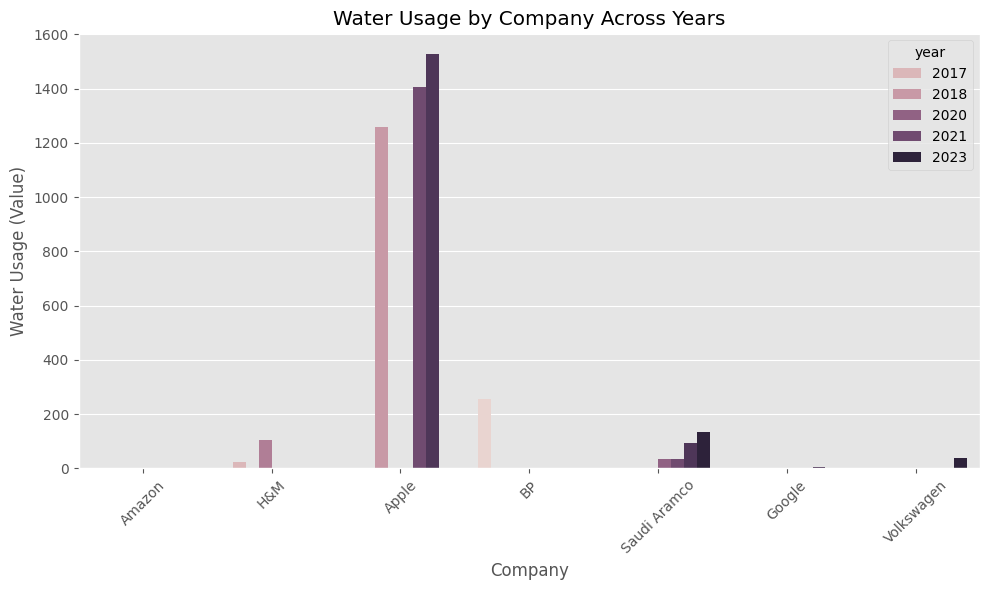

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot style for a cleaner look
plt.style.use('ggplot')

# Plot 1: Average value of each metric by company
plt.figure(figsize=(10, 6))
sns.barplot(data=df_filtered, x='company', y='value', hue='metric')
plt.title('Average Value of Each Metric by Company')
plt.xlabel('Company')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()



# Plot 2: Comparison of Greenhouse Gas Emissions Intensity by company
greenhouse_gas_df = df_filtered[df_filtered['metric'] == 'Greenhouse Gas Emissions Intensity']

plt.figure(figsize=(10, 6))
sns.barplot(data=greenhouse_gas_df, x='company', y='value', hue='year')
plt.title('Greenhouse Gas Emissions Intensity by Company Across Years')
plt.xlabel('Company')
plt.ylabel('Greenhouse Gas Emissions Intensity')
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.tight_layout()
plt.show()


# Plot 3: Water Usage across companies
water_usage_df = df_filtered[df_filtered['metric'] == 'Water Usage']

plt.figure(figsize=(10, 6))
sns.barplot(data=water_usage_df, x='company', y='value', hue='year')
plt.title('Water Usage by Company Across Years')
plt.xlabel('Company')
plt.ylabel('Water Usage (Value)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

